### Import the relevant libraries

In [14]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import glob
import imutils
from imutils import paths
import os
import os.path
import collections
import tensorflow as tf
from tensorflow import keras

In [3]:
#import pytesseract

In [4]:
#pytesseract.pytesseract.tesseract_cmd = r'C:\Windows\System32\ML_PATH\StyleGAN\Tesseract-OCR\tesseract.exe'

### Preprocessing of the input image to extract individual digits:
1. Convert the image to grayscale
2. Get the contours and crop them out of the image

In [56]:
img = cv2.imread("64.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
ret, thresh1 = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
contour, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [57]:
im2=img.copy()

A dictionary (letters) is used to keep track of the order of the digits in the input image (The digits are sorted in the increasing order of the x-coordinate of the contour)

In [58]:
letters=dict()
position=list()
for cnt in contours: 
    x, y, w, h = cv2.boundingRect(cnt) 
    #rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)  
    cropped = im2[y:y + h, x:x + w]  
    #text = pytesseract.image_to_string(cropped)
    #print(text)
    position.append(x)
    letters[x]=cropped

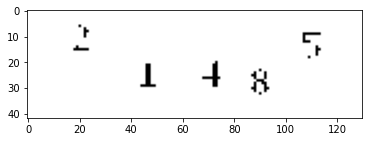

In [59]:
plt.imshow(thresh1,cmap='binary')

In [60]:
position=sorted(position)
letters=collections.OrderedDict(sorted(letters.items()))

In [61]:
len(position)

5

### Checking the order of the extracted images

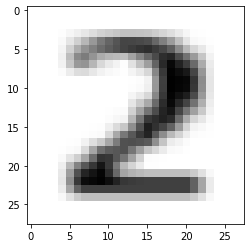

In [67]:
plt.imshow(cv2.resize(letters[position[0]],(28,28),interpolation=cv2.INTER_LINEAR))

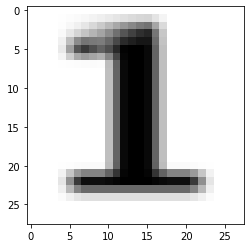

In [68]:
plt.imshow(cv2.resize(letters[position[1]],(28,28),interpolation=cv2.INTER_LINEAR))

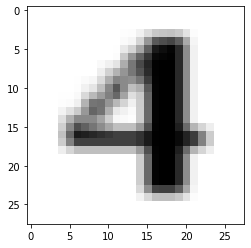

In [69]:
plt.imshow(cv2.resize(letters[position[2]],(28,28),interpolation=cv2.INTER_LINEAR))

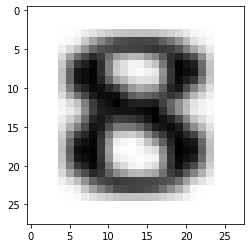

In [70]:
plt.imshow(cv2.resize(letters[position[3]],(28,28),interpolation=cv2.INTER_LINEAR))

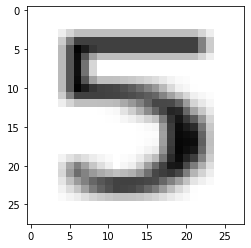

In [71]:
plt.imshow(cv2.resize(letters[position[4]],(28,28),interpolation=cv2.INTER_LINEAR))

### Helper function to solve the captcha

In [63]:
def solver(model,weights,letters,position):
    n=len(position)
    model.load_weights(weights)
    for i in range(n):
        im=letters[position[i]]
        im=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY) 
        im=cv2.resize(im,(28,28),interpolation=cv2.INTER_LINEAR)
        im=np.expand_dims(im,axis=-1)
        im=np.expand_dims(im,axis=0)
        print(np.argmax(model.predict(im),axis=-1))

###  The Convolutional Neural Network

In [64]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,activation='relu',padding='same',input_shape=[28,28,1]))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(128,3,activation='relu',padding='same'))
model.add(keras.layers.Conv2D(128,3,activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(256,3,activation='relu',padding='same'))
model.add(keras.layers.Conv2D(256,3,activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10,activation='softmax'))

In [65]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001),metrics='accuracy')

In [66]:
weights='Captcha Solver.h5'
solver(model,weights,letters,position)

[2]
[1]
[4]
[8]
[5]


### How does the captcha solver work?
We extract each digits of a captcha and feed them to a convolutional neural network trained on 60,000 images of MNIST handwritten digits. The model predicts each digit and prints the result

### Analysis and improvements:
1. The solver confuses between digits '1' ans '7' because of the structural similarities. Hence, we could also train the model on the individual digits extracted from the given dataset along with MNIST images
2. We could use powerful networks with increased training time for better performance